In [155]:
%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt
import sys
import numpy as np
from tqdm import tqdm
import curvedsky as cs
sys.path.append('..')

In [127]:
%load_ext autoreload
%autoreload 2
from cobi.simulation import CMB, BandpassInt, Foreground, Mask, Noise, LATskyC, SATskyC, LATsky
from cobi.spectra import Spectra
from cobi.calibration import Sat4Lat
from cobi.mle import MLE
from cobi.quest import FilterEB, QE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation

In [3]:
dir0 = '/global/cfs/cdirs/sobs/cosmic_birefringence/v0'
dir1 = '/global/cfs/cdirs/sobs/cosmic_birefringence/v1'

## CMB
- Isotropic
- Isotropic time dep.
- Anisotropic

### Isotropic Birefringence
$\begin{pmatrix} E'_{\ell m} \\ B'_{\ell m} \end{pmatrix} =
\begin{pmatrix} \cos(2\beta) & -\sin(2\beta) \\ \sin(2\beta) & \cos(2\beta) \end{pmatrix}
\begin{pmatrix} E_{\ell m} \\ B_{\ell m} \end{pmatrix}.$

In [4]:
cmbobj = CMB(dir0,nside=2048,model='iso',beta=0.35,lensing=True,verbose=True)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic(constant) cosmic birefringence model selected


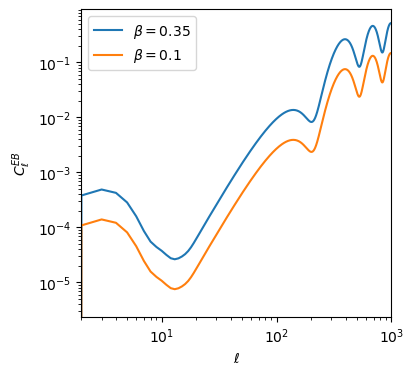

In [10]:
plt.figure(figsize=(4,4))
plt.loglog(cmbobj.get_cb_lensed_spectra(beta=0.35)['eb'],label='$\\beta=0.35$')
plt.loglog(cmbobj.get_cb_lensed_spectra(beta=0.1)['eb'],label='$\\beta=0.1$')
plt.xlabel('$\\ell$')
plt.ylabel('$C_\\ell^{EB}$')
plt.xlim(2,1000)
plt.legend()

### Time-dependent Isotropic Birefringence

$C_{\ell}^{EB} = 4\pi \int \mathrm{d}(\ln q) \, \mathcal{P}_s(q) \, \Delta_{E,\ell}(q) \, \Delta_{B,\ell}(q)$

$\Delta_{E, l}(q) \pm i \Delta_{B, l}(q) \equiv -_{\pm 2}\Delta_{P, l}(\eta_0, q)$

$\pm 2 \Delta_{P, l} (\eta_0, q) = -\frac{3}{4} \sqrt{\frac{(l+2)!}{(l-2)!}} \int_{0}^{\eta_0} d\eta \, \tau' e^{-\tau(\eta)} \Pi \frac{j_l(x)}{x^2} \times \exp\left[\pm 2i \beta(\eta)\right]$


In [11]:
cmbtdobj = CMB(dir1,nside=2048,model='iso_td',mass=1.0,lensing=True,verbose=True) #mass of Axion Like Particles 1 x 10^-28 eV

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic(time dep.) cosmic birefringence model selected


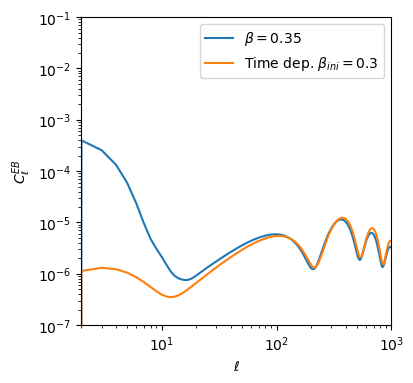

In [18]:
plt.figure(figsize=(4,4))
plt.loglog(cmbobj.get_cb_lensed_spectra(beta=0.35,dl=False)['eb'],label='$\\beta=0.35$')
plt.loglog(cmbtdobj.get_cb_lensed_mass_spectra(dl=True)['eb']/0.3,label='Time dep. $\\beta_{ini}=0.3$')
plt.xlabel('$\\ell$')
plt.ylabel('$C_\\ell^{EB}$')
plt.xlim(2,1000)
plt.ylim(1e-7, 1e-1)
plt.legend()

### Anisotropic Birefringence

$Q' \pm iU' = (Q \pm iU) e^{\pm 2i\beta(\hat{n})}$

$\beta(\hat{n}) = \sum_{LM} \beta_{LM} Y_{LM}(\hat{n})$

$C_{L}^{\beta\beta} = A_{\rm CB} \frac{2\pi}{L(L+1)}$



In [31]:
cmbanisobj =  CMB(dir1,nside=1024,model='aniso',Acb=4.0e-6,lensing=False,verbose=True)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected


(1e-11, 0.0001)

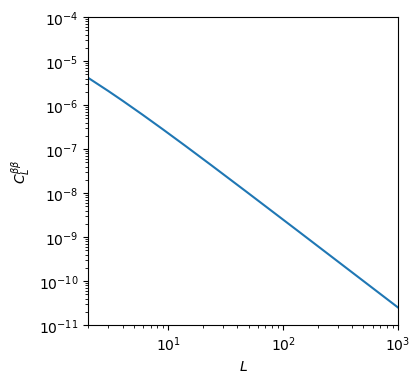

In [32]:
plt.figure(figsize=(4,4))
plt.loglog(cmbanisobj.cl_aa())
plt.xlabel('$L$')
plt.ylabel('$C_L^{\\beta\\beta}$')
plt.xlim(2,1000)
plt.ylim(1e-11, 1e-4)

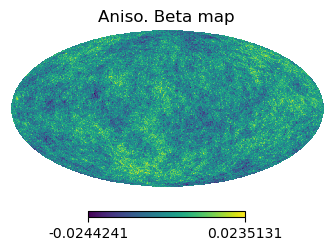

In [36]:
hp.mollview(cmbanisobj.alpha_map(0),sub=121,title='Aniso. Beta map')

## Foregrounds

In [37]:
fg = Foreground(dir0, nside=2048, dust_model=10, sync_model=5, bandpass=False)
fg_bp = Foreground(dir0, nside=2048, dust_model=10, sync_model=5, bandpass=True)

Foreground : INFO - Bandpass integration is disabled
Foreground : INFO - Bandpass integration is enabled


Foreground : INFO - Loading dust Q and U maps for band 27
Foreground : INFO - Loading dust Q and U maps for band 27
Foreground : INFO - Loading dust Q and U maps for band 27
Foreground : INFO - Loading dust Q and U maps for band 27


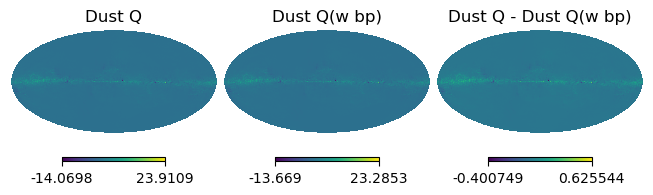

In [38]:
hp.mollview(fg.dustQU('27')[0], title='Dust Q',sub=(1,3,1))
hp.mollview(fg_bp.dustQU('27')[0], title='Dust Q(w bp)',sub=(1,3,2))
#diff
hp.mollview(fg.dustQU('27')[0] - fg_bp.dustQU('27')[0], title='Dust Q - Dust Q(w bp)',sub=(1,3,3))

## Mask

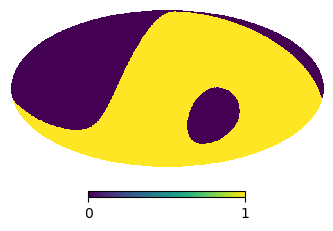

In [63]:
maskobj = Mask(dir0,1024,'LAT',apo_scale=0, apo_method='C2', gal_cut=0.0)
hp.mollview(maskobj.mask, title='',sub=(1,2,1))

In [64]:
maskobj.fsky

0.6385857264200846

## Noise simulation

In [65]:
noiseobj_nc = Noise(nside=2048,fsky=maskobj.fsky,telescope='SAT',sim='NC', atm_noise=True, nsplits=2)
noiseobj_tod = Noise(nside=2048,fsky=maskobj.fsky,telescope='SAT',sim='TOD', nsplits=2)

Noise : INFO - Noise Model:[SAT] White + 1/f noise v3.1.1


Noise : INFO - Noise Model: [SAT] Based on TOD and Map based simulations, directly using SO products.


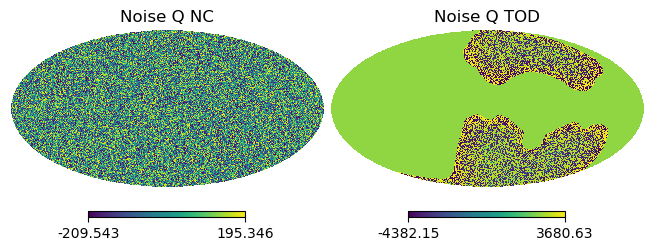

In [70]:
hp.mollview(noiseobj_nc.noiseQU_freq(0,'27-1')[0], sub=(1,2,1), title='Noise Q NC',norm='hist')
hp.mollview(noiseobj_tod.noiseQU_freq(0,'27-1')[0], sub=(1,2,2), title='Noise Q TOD',norm='hist')

## Sky simulation

### CMB + FG + Noise + Systematics

systematics: miscalibration angle, absolute angle and angle error


In [71]:
nside = 2048
cb_model = "iso"
beta = 0.35
alpha = [-0.1,-0.1,0.2,0.2,.15,.15]
alpha_err = 0.1

In [73]:
lat = LATsky(dir0, nside, cb_model, beta, alpha=alpha,alpha_err=alpha_err, bandpass=True,verbose=True,noise_model='NC')

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic(constant) cosmic birefringence model selected
Mask : INFO - Upgrading mask LAT resolution
Noise : INFO - Noise Model:[LAT] White + 1/f noise v3.1.1


Text(0.5, 0, ' $\\alpha$ [deg]')

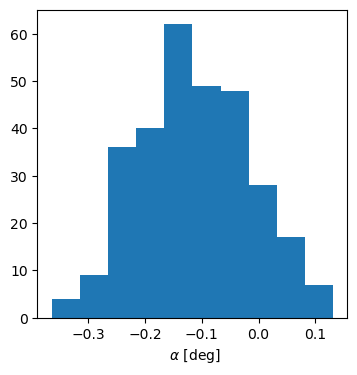

In [81]:
plt.figure(figsize=(4,4))
null = plt.hist(lat.alpha_dict['27-2'],bins=10)
plt.xlabel(' $\\alpha$ [deg]')

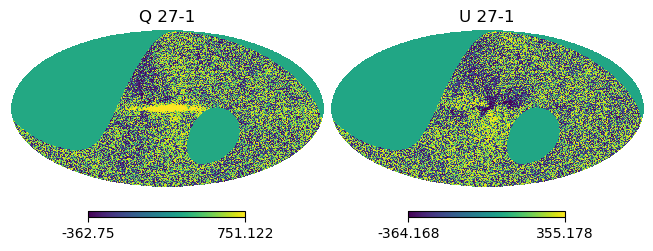

In [83]:
QU27  = lat.obsQU(0,'27-1')
hp.mollview(QU27[0], title='Q 27-1', sub=(1,2,1), norm='hist')
hp.mollview(QU27[1], title='U 27-1', sub=(1,2,2), norm='hist')

# Spectra Calculation

In [84]:
spec = Spectra(lat, dir0, cache=True,parallel=1)

Spectra : INFO - Reading apodised mask from /global/cfs/cdirs/sobs/cosmic_birefringence/v0/spectra_2048_aposcale2p0/workspaces/mask_N2048_aposcale2p0_CO_PS.fits
Spectra : INFO - Reading coupling Matrix from /global/cfs/cdirs/sobs/cosmic_birefringence/v0/spectra_2048_aposcale2p0/workspaces/coupling_matrix_N2048_fsky0p55_aposcale2p0_bw1_CO_PS.fits
Spectra : INFO - Parallelized single loop


In [ ]:
spec.obs_x_obs(0).shape

(12, 12, 3, 2001)

# Analysis Pipeline
- Likelihood (SAT Calibrating LAT)
- Minami-Komastu Method
- Anisotopic Reconstruction

## SAT calibrating LAT
### 90 and 150 GHz

In [87]:
nside = 2048
cb_model = "iso"
beta = 0.35
nc = 'TOD'
alpha_lat = [0.2,0.2]
alpha_lat_err = 0.2
alpha_sat_err = 0.1

In [88]:
lat = LATskyC(dir1, nside, cb_model, beta, alpha=alpha_lat,alpha_err=alpha_lat_err, bandpass=True,verbose=True,nsplits=2,noise_model=nc)
sat = SATskyC(dir1, nside, cb_model, beta, alpha_err=alpha_sat_err, bandpass=False,verbose=True,nsplits=2,noise_model=nc)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic(constant) cosmic birefringence model selected
Noise : INFO - Noise Model: [LAT] Based on TOD and Map based simulations, directly using SO products.
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic(constant) cosmic birefringence model selected
/pscratch/sd/l/lonappan/software_pkgs/cb/lib/python3.10/site-packages/so_models_v3/SO_Noise_Calculator_Public_v3_1_1.py:215: RuntimeWarning: divide by zero encountered in scalar divide
  cov_weight[i,j] += ( tube_count * N_tels /
Noise : INFO - Noise Model: [SAT] Based on TOD and Map based simulations, directly using SO products.


In [89]:
latspectra = Spectra(lat,dir1,parallel=0,galcut=40,binwidth=5)
satspectra = Spectra(sat,dir1,parallel=0,galcut=40,CO=False,PS=False,binwidth=5)

Spectra : INFO - Reading apodised mask from /global/cfs/cdirs/sobs/cosmic_birefringence/v1/spectra_2048_aposcale2p0/workspaces/mask_N2048_aposcale2p0_CO_PS_G40.fits
Spectra : INFO - Reading coupling Matrix from /global/cfs/cdirs/sobs/cosmic_birefringence/v1/spectra_2048_aposcale2p0/workspaces/coupling_matrix_N2048_fsky0p24_aposcale2p0_bw5_CO_PS_G40.fits
Spectra : INFO - No parallelization
Spectra : INFO - Reading apodised mask from /global/cfs/cdirs/sobs/cosmic_birefringence/v1/spectra_2048_aposcale2p0/workspaces/mask_N2048_aposcale2p0_G40.fits
Spectra : INFO - Reading coupling Matrix from /global/cfs/cdirs/sobs/cosmic_birefringence/v1/spectra_2048_aposcale2p0/workspaces/coupling_matrix_N2048_fsky0p09_aposcale2p0_bw5_G40.fits
Spectra : INFO - No parallelization


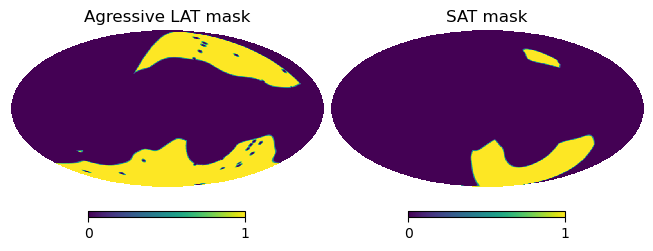

In [94]:
hp.mollview(latspectra.mask,sub=(1,2,1),title='Agressive LAT mask')
hp.mollview(satspectra.mask,sub=(1,2,2),title='SAT mask')

In [97]:
calibobj = Sat4Lat(dir1,lmin=100,lmax=3000,latlib=latspectra,satlib=satspectra,sat_err=alpha_sat_err,beta=0.35)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic(constant) cosmic birefringence model selected


Removed no burn in


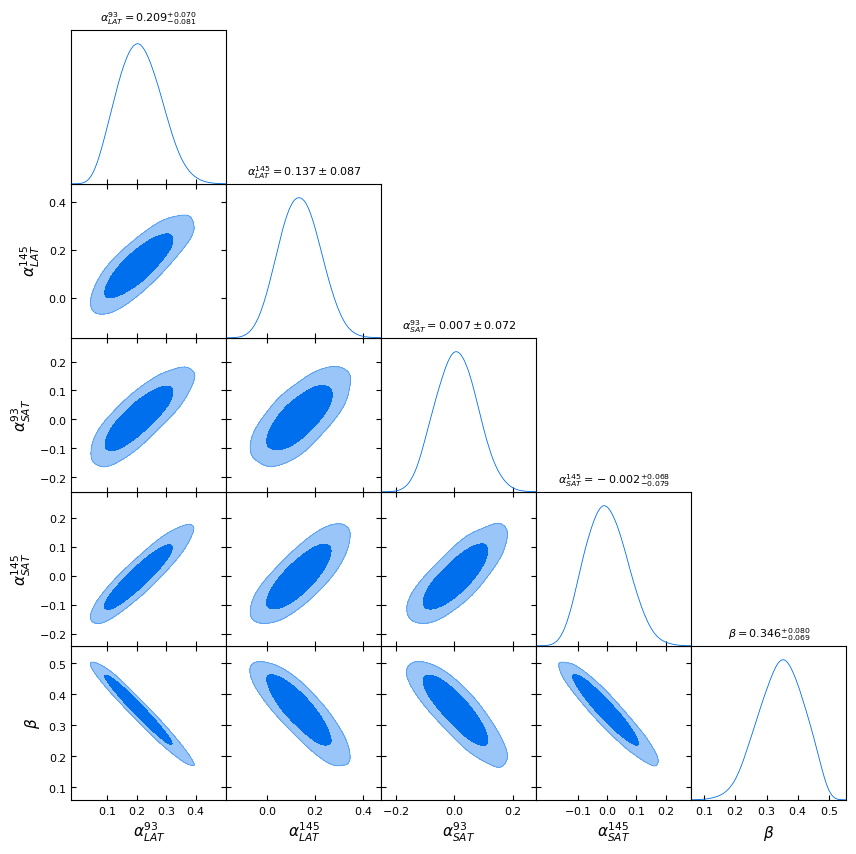

In [102]:
calibobj.plot_getdist(nwalkers=100,nsamples=2000)

## Minami-Komastu Method

In [104]:
nside = 2048
cb_model = "iso"
beta = 0.35
alpha = [-0.1,-0.1,0.2,0.2,.15,.15]
alpha_err = 0.1
fit = "Ad + beta + alpha"
binwidth = 10
bmin = 50
bmax = 2000

In [106]:
lat = LATsky(dir0, nside, cb_model, beta, alpha=alpha,alpha_err=alpha_err, bandpass=True,verbose=True,noise_model='NC')
spec = Spectra(lat, dir0, cache=True, parallel=0)

CMB : INFO - Loading CMB power spectra from file
INFO:CMB:Loading CMB power spectra from file
CMB : INFO - Isotropic(constant) cosmic birefringence model selected
INFO:CMB:Isotropic(constant) cosmic birefringence model selected
Noise : INFO - Noise Model:[LAT] White + 1/f noise v3.1.1
INFO:Noise:Noise Model:[LAT] White + 1/f noise v3.1.1
Spectra : INFO - Reading apodised mask from /global/cfs/cdirs/sobs/cosmic_birefringence/v0/spectra_2048_aposcale2p0/workspaces/mask_N2048_aposcale2p0_CO_PS.fits
INFO:Spectra:Reading apodised mask from /global/cfs/cdirs/sobs/cosmic_birefringence/v0/spectra_2048_aposcale2p0/workspaces/mask_N2048_aposcale2p0_CO_PS.fits
Spectra : INFO - Reading coupling Matrix from /global/cfs/cdirs/sobs/cosmic_birefringence/v0/spectra_2048_aposcale2p0/workspaces/coupling_matrix_N2048_fsky0p55_aposcale2p0_bw1_CO_PS.fits
INFO:Spectra:Reading coupling Matrix from /global/cfs/cdirs/sobs/cosmic_birefringence/v0/spectra_2048_aposcale2p0/workspaces/coupling_matrix_N2048_fsky0p55

In [107]:
mle = MLE(dir0,spec,fit, alpha_per_split=False,rm_same_tube=True,binwidth=binwidth,bmin=bmin,bmax=bmax)

CMB : INFO - Loading CMB power spectra from file
INFO:CMB:Loading CMB power spectra from file
CMB : INFO - Isotropic(constant) cosmic birefringence model selected
INFO:CMB:Isotropic(constant) cosmic birefringence model selected


Fitting a common polarisation angle per frequency
Don't use cross-spectra of bands within the same optical tube


In [113]:
mle.estimate_angles(1)['beta']

0.3139254595068103

In [114]:
mle.estimate_angles(1)['93']

0.20593567265690046

## Anisotropic Birefringence

In [129]:
alpha = [-0.1,-0.1,0.2,0.2,.15,.15]
alpha_err = 0.1
latsky = LATsky(dir1, nside=1024, cb_model='aniso',Acb=4.0e-6, AEcb=-1.0e-3,lensing=False,alpha=alpha,alpha_err=alpha_err,nsplits=1)
mask = Mask(latsky.basedir, latsky.nside,'LATxGAL', 2, gal_cut=0.8)

CMB : INFO - Loading CMB power spectra from file
INFO:CMB:Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
INFO:CMB:Anisotropic cosmic birefringence model selected


Noise : INFO - Noise Model:[LAT] White + 1/f noise v3.1.1
INFO:Noise:Noise Model:[LAT] White + 1/f noise v3.1.1
Mask : INFO - The given galactic cut value seems in fsky and it corresponds to 80.0% of sky
INFO:Mask:The given galactic cut value seems in fsky and it corresponds to 80.0% of sky


### 1. Component Sep. - Harmonic ILC

In [118]:
EB,NL = latsky.HILC_obsEB(0)

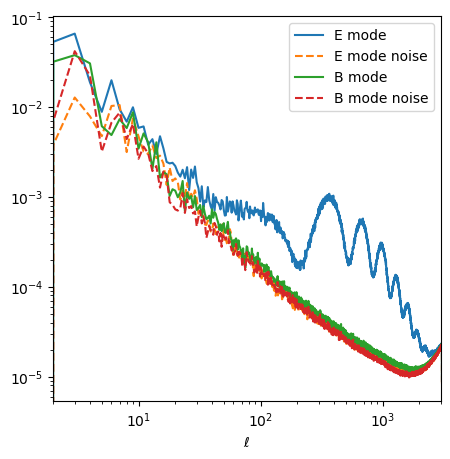

In [126]:
plt.figure(figsize=(5,5))
plt.loglog(hp.alm2cl(EB[0]),label='E mode')
plt.loglog(NL[0],label='E mode noise',ls='--')
plt.loglog(hp.alm2cl(EB[1]),label='B mode')
plt.loglog(NL[1],label='B mode noise',ls='--')
plt.xlabel('$\\ell$')
plt.xlim(2,3000)
plt.legend()

### 2. Filtering - C inverse 
$\tilde{d} = (S + N)^{-1} d$

pixel-domain filtering

In [130]:
filtobj = FilterEB(latsky, mask, lmax=3000, sht_backend='ducc') # uses ducc0 instead of Healpix

/global/u2/l/lonappan/workspace/cobi/examples/../cobi/quest.py:131: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/(self.cl_len[1,:len(ne)]  + ne))


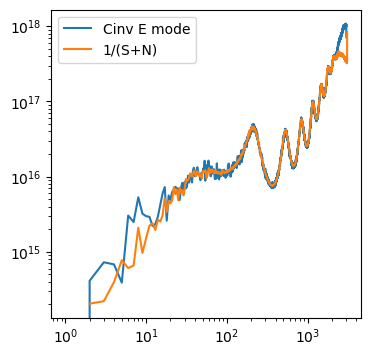

In [134]:
filtobj.plot_cinv(0)

### 3. Quadratic Estimator

In [135]:
qeobj = QE(filtobj,lmin=100,lmax=3000,recon_lmax=2048)

In [136]:
qcl = []
for i in tqdm(range(50)):
    qcl.append(qeobj.qcl(i))
qcl = np.array(qcl)

100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


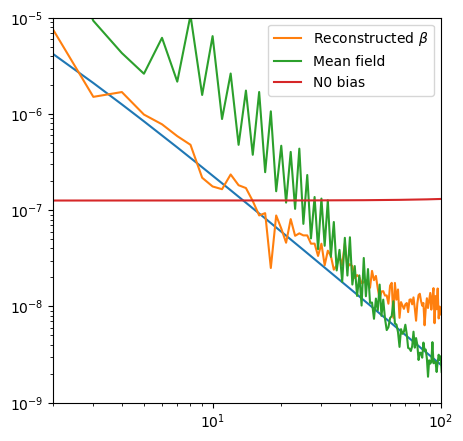

In [153]:
plt.figure(figsize=(5,5))
plt.loglog(qeobj.cl_aa)
plt.loglog(qcl.mean(axis=0), label="Reconstructed $\\beta$")
plt.loglog(qeobj.mean_field_cl(),label='Mean field')
plt.loglog(qeobj.norm, label='N0 bias')
plt.ylim(1e-9, 1e-5)
plt.xlim(2,100)
plt.legend()

In [197]:
out_map = cs.utils.hp_alm2map(alm=(qeobj.qlm(0)-qeobj.mean_field())[:11,:11],nside=32,lmax=10,mmax=10)
input_map =qeobj.filter.sky.cmb.alpha_map(0)
alm = cs.utils.hp_map2alm(map=input_map,lmax=10,mmax=10,nside=1024)
input_map = cs.utils.hp_alm2map(alm=alm,nside=32,lmax=10,mmax=10)
mask = hp.ud_grade(Mask(dir0,256,'LATxGAL',apo_scale=0, apo_method='C2', gal_cut=0.8).mask,32)
out_map[mask==0] = hp.UNSEEN
input_map[mask==0] = hp.UNSEEN

Mask : INFO - The given galactic cut value seems in fsky and it corresponds to 80.0% of sky
INFO:Mask:The given galactic cut value seems in fsky and it corresponds to 80.0% of sky


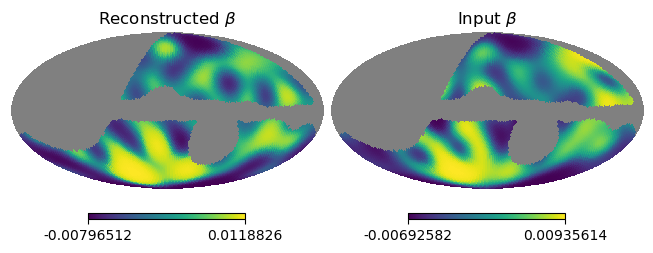

In [198]:
hp.mollview(out_map, norm='hist',sub=(1,2,1),title='Reconstructed $\\beta$')
hp.mollview(input_map, norm='hist',sub=(1,2,2),title='Input $\\beta$')